In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Data Preprocessing and Augmentation

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rizwan123456789/potato-disease-leaf-datasetpld")

print("Path to dataset files:", path)

100%|██████████| 37.4M/37.4M [00:00<00:00, 90.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rizwan123456789/potato-disease-leaf-datasetpld/versions/1


In [ ]:
train_dir = os.path.join(path, "PLD_3_Classes_256", "Training")
val_dir = os.path.join(path, "PLD_3_Classes_256", "Testing")
test_dir= os.path.join(path, "PLD_3_Classes_256", "Validation")

ImageDataGenerator = Image Loader + Preprocessor + Augmenter

1. To load images in batches (not all at once)

If you have thousands of images, loading all into memory will crash your system.

ImageDataGenerator loads images batch by batch, so RAM is not overloaded.


2. To apply Image Augmentation

3. Automatic preprocessing

It also handles tasks like:

rescaling (rescale=1./255)

normalization

converting images to tensors

resizing to target size

In [ ]:
# Image Data Generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3251 images belonging to 3 classes.
Found 405 images belonging to 3 classes.
Found 416 images belonging to 3 classes.


Load VGG16 Model and Add Custom Layers

In [ ]:
# --------------- Load the VGG16 model pre-trained on ImageNet, excluding the top (fully connected) layers. --------------
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# ------- Add custom fully connected layers on top of the VGG16 base. ---------------------
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)  # Assuming 3 classes

model = Model(inputs=base_model.input, outputs=predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Freeze Base Layers: Freeze all layers in the VGG16 base model to prevent them from being updated during the training.

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

Compile the model

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])   # label mode = categorical thats why

Add Early stopping Callback to stop the training when it achieves optimal validation accuracy , This is mainly to prevent the overfitting of the model and to make the model more generalized

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5, # Stops training when there is no change for first 5 consecutive validation accuracy values
    verbose=1,
    mode='max',
    restore_best_weights=True
)

Train the model

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,  # Set a high number for epochs; early stopping will handle stopping early.
    callbacks=[early_stopping]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1917s 19s/step - accuracy: 0.5584 - loss: 1.0631 - val_accuracy: 0.8568 - val_loss: 0.4373
Epoch 2/10
  1/101 ━━━━━━━━━━━━━━━━━━━━ 27:24 16s/step - accuracy: 0.8438 - loss: 0.4367

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


101/101 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.8438 - loss: 0.4367 - val_accuracy: 0.8672 - val_loss: 0.4231
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1935s 19s/step - accuracy: 0.8625 - loss: 0.3848 - val_accuracy: 0.8828 - val_loss: 0.3769
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.8750 - loss: 0.3159 - val_accuracy: 0.8802 - val_loss: 0.3870
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1930s 19s/step - accuracy: 0.8762 - loss: 0.3340 - val_accuracy: 0.9089 - val_loss: 0.2999
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.9375 - loss: 0.2219 - val_accuracy: 0.9089 - val_loss: 0.2997
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1879s 18s/step - accuracy: 0.9080 - loss: 0.2645 - val_accuracy: 0.9167 - val_loss: 0.2946
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.9062 - loss: 0.2397 - val_accuracy: 0.9036 - val_loss: 0.2988
Epoch 9/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1834s 18s/step - accuracy: 0.9290 - loss: 0.2106 - val_accurac

In [ ]:
# Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_accuracy}')

# Save the Model
model.save('vgg16_image_classification_model.h5')

13/13 ━━━━━━━━━━━━━━━━━━━━ 216s 17s/step - accuracy: 0.8850 - loss: 0.3075


Test accuracy: 0.8870192170143127


Testing The model

Create Class label dictionary

In [1]:
import json

class_indices = {v: k for k, v in train_generator.class_indices.items()}  # Get class labels

with open("class_names.json","w") as f:
    json.dump(class_indices,f,indent=4)

NameError: name 'train_generator' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Disease :  Late_Blight


/tmp/ipython-input-3403809419.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_val=int(pred)


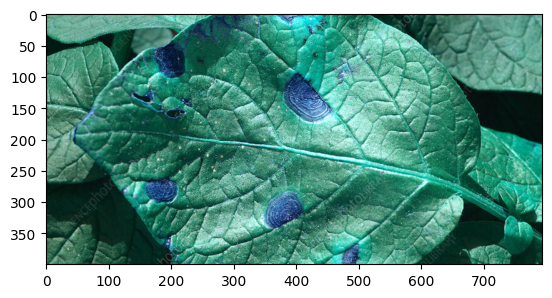

In [ ]:
import cv2
import json
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

model_path="vgg16_image_classification_model.h5"
model=load_model(model_path)

with open("class_names.json") as f:
    class_dict=json.load(f)

test_image_path=r"/content/dataset-cover.jpg" # Add your image Path here
plt.imshow(cv2.imread(test_image_path))

image_obj=cv2.imread(test_image_path)
test_image=cv2.resize(image_obj,(224, 224))

#==========Convert image to numpy array and normalize ==========
test_image=img_to_array(test_image)/255
#=======================change dimention 3D to 4D ==============
test_image=np.expand_dims(test_image,axis=0)

result=model.predict(test_image)

pred=np.argmax(result,axis=1)

predicted_val=int(pred)

predicted_disease=class_dict[str(predicted_val)]
print("Disease : ",predicted_disease)

In [18]:
from tensorflow.keras.applications import VGG16

# Download VGG16 with ImageNet weights
model = VGG16(
    weights='imagenet',   # triggers download
    include_top=True,     # includes fully connected layers
    input_shape=(224, 224, 3)
)

model.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.applications import VGG16

model = VGG16(weights='imagenet')


In [20]:
img = '/content/images.webp'

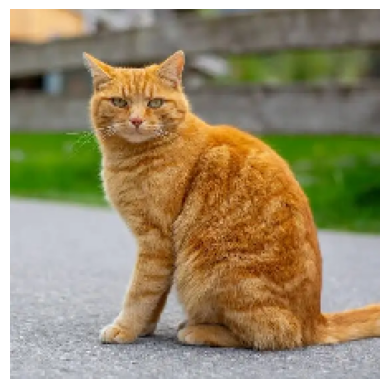

In [21]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

img_path = "/content/images.webp"   # path to your cat image

img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)


In [22]:
preds = model.predict(x)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step


In [25]:
#preds

In [23]:
from tensorflow.keras.applications.vgg16 import decode_predictions

decoded = decode_predictions(preds, top=3)
for label in decoded[0]:
    print(label)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
('n02123159', 'tiger_cat', np.float32(0.83559257))
('n02123045', 'tabby', np.float32(0.11333174))
('n02124075', 'Egyptian_cat', np.float32(0.03270822))
